In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
class CruiseController:
    def __init__(self, verbose=False):
        self.verbose=verbose
        self.mapping = self.get_mappings()
        self.rule_base = self.get_rules()
        self.speed_mf = self.get_speed_mf()
        self.acc_mf = self.get_acc_mf()
        self.throttle_values = self.get_throttle_values()
        self.throttle_base = self.throttle_values['PL'] - self.throttle_values['ZE']

    @staticmethod
    def get_mappings():
        return {
            'NL': 0,  # Negative Large
            'NM': 1,  # Negative Medium
            'ZE': 2,  # Zero
            'PM': 3,  # Positive Medium
            'PL': 4  # Positive Large
        }

    @staticmethod
    def get_rules():
        return [
            ['PL', 'PL', 'PL', 'PM', 'ZE'],
            ['PL', 'PL', 'PM', 'ZE', 'NM'],
            ['PL', 'PM', 'ZE', 'NM', 'NL'],
            ['PM', 'ZE', 'NM', 'NL', 'NL'],
            ['ZE', 'NM', 'NL', 'NL', 'NL'],
        ]

    @staticmethod
    def get_speed_mf():
        return {
            'NL': lambda x: 1 if x < -100 else (0 if x > -50 else -0.02 * x - 1),
            'NM': lambda x: 0 if x < -100 or x > 0 else (0.02 * x + 2 if x < -50 else -0.02 * x),
            'ZE': lambda x: 0 if abs(x) > 50 else (0.02 * x + 1 if x < 0 else -0.02 * x + 1),
            'PM': lambda x: 0 if x > 100 or x < 0 else (-0.02 * x + 2 if x > 50 else 0.02 * x),
            'PL': lambda x: 1 if x > 100 else (0 if x < 50 else 0.02 * x - 1)
        }

    @staticmethod
    def get_acc_mf():
        return {
            'NL': lambda x: 1 if x < -40 else (0 if x > -20 else -0.05 * x - 1),
            'NM': lambda x: 0 if x < -40 or x > 0 else (0.05 * x + 2 if x < -20 else -0.05 * x),
            'ZE': lambda x: 0 if abs(x) > 20 else (0.05 * x + 1 if x < 0 else -0.05 * x + 1),
            'PM': lambda x: 0 if x > 40 or x < 0 else (-0.05 * x + 2 if x > 20 else 0.05 * x),
            'PL': lambda x: 1 if x > 40 else (0 if x < 20 else 0.05 * x - 1)
        }

    @staticmethod
    def get_throttle_values():
        return {
            'NL': -20,
            'NM': -10,
            'ZE': 0,
            'PM': 10,
            'PL': 20
        }

    @staticmethod
    def crisp_to_fuzzy(val, mf):
        fuzzy_values = []
        for x, myu_x in mf.items():
            if myu_x(val) > 0: fuzzy_values.append((x, myu_x(val)))
        return fuzzy_values

    def fuzzify(self, speed_diff, acc):
        return self.crisp_to_fuzzy(speed_diff, self.speed_mf), self.crisp_to_fuzzy(acc, self.acc_mf)

    def apply_rule_base(self, speed, acc):
        throttle_fuzzy = []
        for s in speed:
            for a in acc:
                i, j = self.mapping[s[0]], self.mapping[a[0]]
                throttle_fuzzy.append((self.rule_base[i][j], min(s[1], a[1])))
        return throttle_fuzzy

    def get_throttle_area(self, x):
        y = self.throttle_base * x
        return 0.5 * (self.throttle_base - (1 - x) * y)

    def defuzzify(self, throttle_fuzzy):
        areas = []
        for tf in throttle_fuzzy:
            areas.append((self.throttle_values[tf[0]], self.get_throttle_area(tf[1])))
        throttle = 0
        total_area = 0
        for a in areas:
            throttle += a[0] * a[1]
            total_area += a[1]
        return throttle / total_area

    def get_throttle(self, speed_diff, acc):
        speed_fuzzy, acc_fuzzy = self.fuzzify(speed_diff, acc)
        throttle_fuzzy = self.apply_rule_base(speed_fuzzy, acc_fuzzy)
        throttle = self.defuzzify(throttle_fuzzy)
        
        if self.verbose:
            print('speed_fuzzy:',speed_fuzzy)
            print('acc_fuzzy:',acc_fuzzy)
            print('throttle_fuzzy:',throttle_fuzzy)
        return throttle


In [3]:
controller = CruiseController(verbose=True)
throttle = controller.get_throttle(speed_diff=0, acc=10)
print('Throttle: {}\n'.format(throttle))

speed_fuzzy: [('ZE', 1.0)]
acc_fuzzy: [('ZE', 0.5), ('PM', 0.5)]
throttle_fuzzy: [('ZE', 0.5), ('NM', 0.5)]
Throttle: -5.0



In [4]:
x = []
y = []
z = []

controller = CruiseController(verbose=False)
for speed_diff in range (-100,100):
    for acc in range(-40,40):
#         print('speed_diff: {}, acc: {}'.format(speed_diff, acc))
        throttle = controller.get_throttle(speed_diff=speed_diff, acc=acc)
#         print('Throttle: {}\n'.format(throttle))
        
        x.append(speed_diff)
        y.append(acc)
        z.append(throttle)

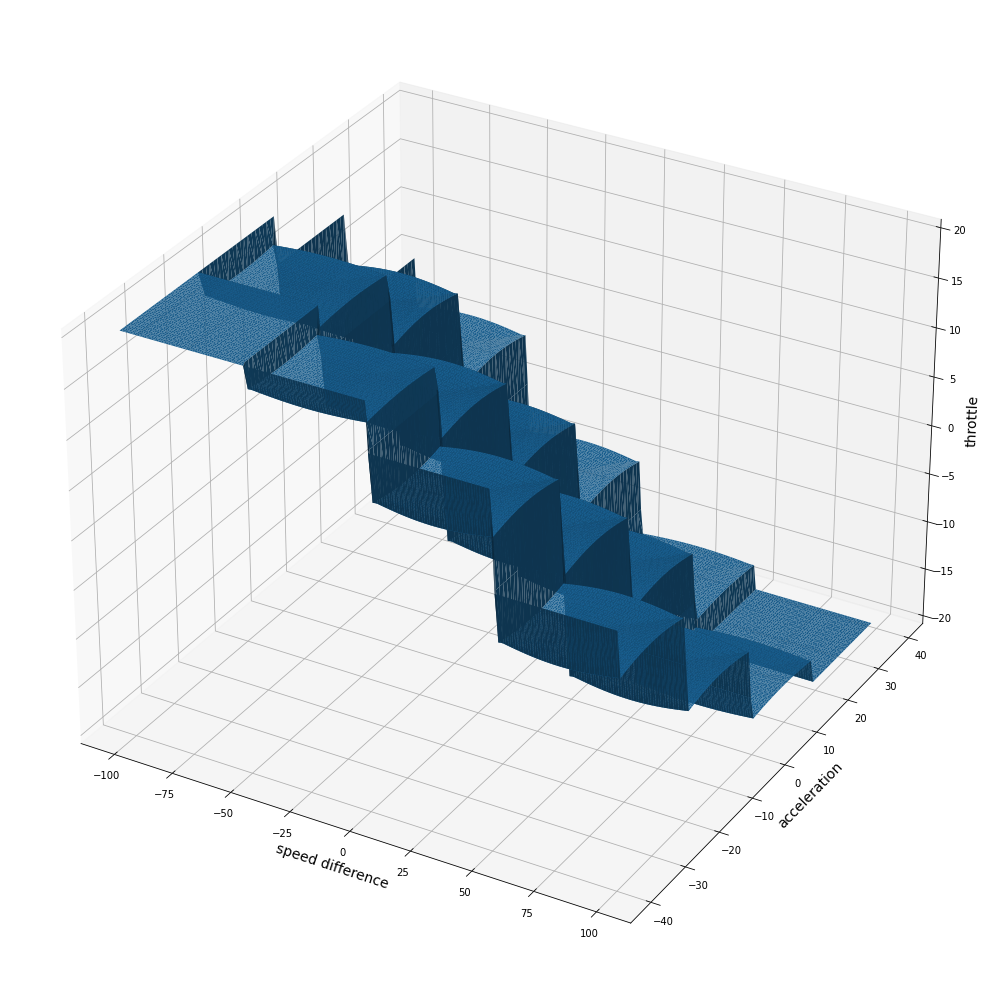

In [5]:
fig = plt.figure(figsize=(32,18))
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z)
ax.set_xlabel('speed difference', fontsize=14)
ax.set_ylabel('acceleration', fontsize=14)
ax.set_zlabel('throttle', fontsize=14)
plt.show()